### Symbolic Regressor Example v1.0
<i>Use of the gplearn Symbolic Regressor class.</i>
<P/><P/>
Mark Maupin<BR>
October 22, 2020

In [1]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm

In [2]:
def plot_fitness_curves(pop, prod):
    
    fig, ax = plt.subplots()
    x = np.arange(len(pop[0].run_details_['best_fitness']))

    for i, gp in enumerate(pop):
        plt.plot(x, gp.run_details_['best_fitness'], label="k="+str(i))
    
    plt.plot(x, prod.run_details_['best_fitness'], label="prod")
    plt.title("Best Fitness by Fold Through Time")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.legend()

In [3]:
def SymbolicRegressorFactory(f_names):

    return SymbolicRegressor(
        population_size=2000, 
        generations=25, 
        tournament_size=20, 
        stopping_criteria=0.0, 
        const_range=(0.0, 0.0), 
        init_depth=(2, 6), 
        init_method='half and half', 
        function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'abs'], 
        metric='mean absolute error', 
        parsimony_coefficient=0.001, 
        p_crossover=0.9, 
        p_subtree_mutation=0.01, 
        p_hoist_mutation=0.01, 
        p_point_mutation=0.01, 
        p_point_replace=0.05, 
        max_samples=1.0, 
        feature_names=f_names, 
        warm_start=False, 
        low_memory=False, 
        n_jobs=-1, 
        verbose=0, 
        random_state=None)

In [4]:
def partition_data(src, oos=0.2, folds=5, targets=1, shuffle=True, rand_seed=None):    
    df      = pd.read_csv(src)
    
    X       = df[df.columns[:-targets]]
    X_all   = np.array(X.values.tolist())
    y       = df[df.columns[-targets]]
    y_all   = np.array(list(y.values))
        
    f_names = list(df.columns[:-targets])
    
    X_in_sample, X_out_sample, y_in_sample, y_out_sample = train_test_split(X_all, y_all, test_size=oos)
    kf = KFold(n_splits=folds, random_state=rand_seed, shuffle=shuffle);
    
    return (X_in_sample, X_out_sample, y_in_sample, y_out_sample, kf, f_names)

#### Import Data

In [5]:
src       = r"C:\Users\markr\Projects\Software\FormulaBot\data\hypotenuse_01.csv"
oos       = 0.20
folds     = 5
targets   = 1
shuffle   = True
rand_seed = 101

X_in_sample, X_out_sample, y_in_sample, y_out_sample, kf, f_names = partition_data(src, oos, folds, targets, shuffle, rand_seed)

#### Split Data Into k-Folds, Compute Fitness

In [6]:
results = []

with tqdm(total=kf.n_splits) as pbar:
    for train_index, test_index in kf.split(X_in_sample):
        X_train, X_test = X_in_sample[train_index], X_in_sample[test_index]
        y_train, y_test = y_in_sample[train_index], y_in_sample[test_index]

        gp = SymbolicRegressorFactory(f_names)
        
        gp.fit(X_train, y_train);
        results.append((gp, gp.score(X_train,y_train), gp.score(X_test,y_test)))
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.28s/it]


In [7]:
gp = SymbolicRegressorFactory(f_names)
gp.fit(X_train, y_train);
score = gp.score(X_out_sample, y_out_sample)

#### Report Validation and Out of Sample Testing

In [8]:
gps, train, test = zip(*results)
print("".ljust(12),"|","Training:".center(20),"|","Testing:".center(20))
print("".center(61, "-"))
print("Max:".ljust(12),"|",str(max(train)).center(20),"|",str(max(test)).center(20) )
print("Average:".ljust(12),"|",str(sum(train)/len(train)).center(20),"|",str(sum(test)/len(test)).center(20) )
print("Min:".ljust(12),"|",str(min(train)).center(20),"|",str(min(test)).center(20) )
print("".center(61, "-"))
print("Out Sample:".ljust(12),"|","N/A".center(20),"|",str(score).center(20))

             |      Training:       |       Testing:      
-------------------------------------------------------------
Max:         |         1.0          |         1.0         
Average:     |  0.9999999999981849  |  0.9999999999981801 
Min:         |  0.9999999999909248  |  0.9999999999909006 
-------------------------------------------------------------
Out Sample:  |         N/A          |         1.0         


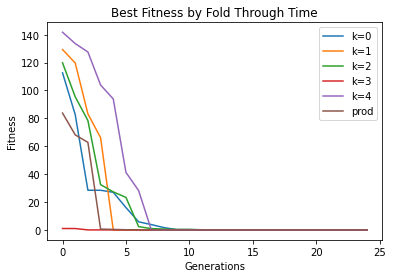

In [9]:
plot_fitness_curves(gps, gp)

#### Best Program

sqrt(add(mul(B, B), mul(A, A)))


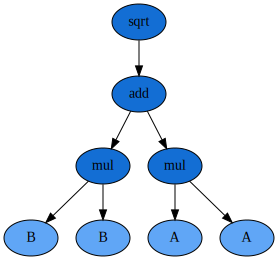

In [17]:
k = test.index(max(test))
print(gps[k]._program)
dot_data = gps[k]._program.export_graphviz()
graphviz.Source(dot_data)

#### Display Program as Decision Tree

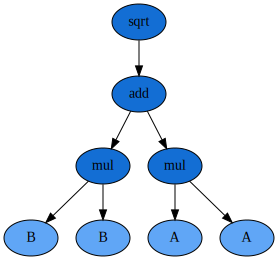

In [12]:
dot_data = gp._program.export_graphviz()
graphviz.Source(dot_data)

## And that is the correct answer!